## <font>Series de tiempo</font>

[YouTube](https://www.youtube.com/watch?v=9twZc5uXB5k&list=PLISuMnTdVU-wJ4nvYFjji2EGlONuOwfVg&index=3)

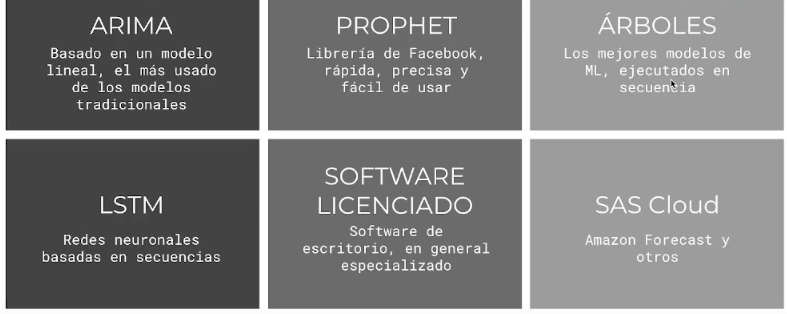

El análisis de series de tiempo se suele utilizar para proyectar o pronosticar la evolución de una variable a lo largo del tiempo, a partir de información previa sobre esa misma variable. Es decir, tenemos que proyectar (plotear) una variable determinada (eje y) en función del tiempo (eje x).

En este caso, nuestra variable de interés el el precio de la cebolla en India, en el dataset contamos con información desagregada por ciudad. En principio, realizaremos un análisis exploratorio para observar su evolución temporal (1) y, luego, pronosticaremos el precio para los próximos periodos de tiempo con una serie de modelos básicos (2) y con otros más avanzados (3), incluyendo el modelo ARIMA.

## Analisis exploratorio y preprocessing

El dataset tiene tres columnas (features o variables) son sobre la ubicación del mercado mayorista donde se vendió cebolla:

    state: Esta es la abreviatura de 2/3 letras para el estado en India (PB es Punjab, etc.)
    ciudad: Esta es la ciudad en India (ABOHAR, BANGALORE y así sucesivamente)
    mercado: esta es una cadena con la combinación del estado y la ciudad

Tres están relacionados con la fecha de la transacción:

    mes: mes en enero, febrero y así sucesivamente.
    año: año en YYYY representatión
    fecha: la combinación de los dos anteriores.

Cuatro son acerca de la cantidad y el precio en este mercado mayorista (todas numéricas).

    cantidad: La cantidad de cebolla que llega al mercado en ese mes en quintales (100 kg)
    priceMin: el precio mínimo en el mes en Rs./quintal
    priceMax: el precio máximo en el mes en Rs./quintal
    priceMod: el precio modal en el mes en Rs./quintal


## Generalizando, identificamos distintas ESTRUCTURAS DE DATOS


    CATEGORICA: estado, ciudad, mercado
    INTERVALO DE TIEMPO: mes, año, fecha
    CUANTITATIVA: cantidad, precioMin, priceMax, priceModal


### Importar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/onion_prices.csv')
df.shape

(10227, 10)

In [3]:
df

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012
...,...,...,...,...,...,...,...,...,...,...
10222,YEOLA(MS),December,2011,131326,282,612,526,MS,YEOLA,December-2011
10223,YEOLA(MS),December,2012,207066,485,1327,1136,MS,YEOLA,December-2012
10224,YEOLA(MS),December,2013,215883,472,1427,1177,MS,YEOLA,December-2013
10225,YEOLA(MS),December,2014,201077,446,1654,1456,MS,YEOLA,December-2014


In [5]:
df.dtypes

market      object
month       object
year         int64
quantity     int64
priceMin     int64
priceMax     int64
priceMod     int64
state       object
city        object
date        object
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10227 entries, 0 to 10226
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
 9   date      10227 non-null  object
dtypes: int64(5), object(5)
memory usage: 799.1+ KB


In [6]:
# Cambiamos el formado de la columna 'date'
df.date = pd.DatetimeIndex(df.date)
df['date'].dtype
# es equivalente a datetime64

dtype('<M8[ns]')

In [7]:
# Podemos reindexar nuestro dataframe 
df = df.sort_values(by = "date")
df.index = pd.PeriodIndex(df.date, freq='M')
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


In [8]:
len(pd.unique(df.year)), pd.unique(df.year)

(21,
 array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016],
       dtype=int64))

In [9]:
len(pd.unique(df.city)), pd.unique(df.city)

(117,
 array(['LASALGAON', 'NIPHAD', 'SAIKHEDA', 'SINNAR', 'PIMPALGAON',
        'LONAND', 'CHAKAN', 'MANMAD', 'BHAVNAGAR', 'MAHUVA', 'PUNE',
        'AHMEDNAGAR', 'HUBLI', 'RAHURI', 'DEWAS', 'DHAVANGERE', 'BOMBORI',
        'DINDIGUL', 'NASIK', 'GONDAL', 'INDORE', 'DHULIA', 'HASSAN',
        'RAJKOT', 'DELHI', 'KARNAL', 'MANDSOUR', 'JAIPUR', 'KALVAN',
        'LUCKNOW', 'CHICKBALLAPUR', 'SHIMLA', 'KURNOOL', 'SURAT', 'YEOLA',
        'KANPUR', 'KOLAR', 'MALEGAON', 'BELGAUM', 'PATNA', 'SOLAPUR',
        'KOLHAPUR', 'SRINAGAR', 'KOLKATA', 'BANGALORE', 'NAGPUR',
        'HYDERABAD', 'MUMBAI', 'CHENNAI', 'AMRITSAR', 'MADURAI',
        'GUWAHATI', 'JALANDHAR', 'RANCHI', 'UJJAIN', 'BIJAPUR', 'JUNNAR',
        'TRIVENDRUM', 'JAMMU', 'AHMEDABAD', 'SATANA', 'ABOHAR', 'AGRA',
        'VARANASI', 'BHUBNESWER', 'JALGAON', 'SANGALI', 'SANGAMNER',
        'BHOPAL', 'JODHPUR', 'SHRIRAMPUR', 'BHATINDA', 'DEVALA', 'PATIALA',
        'LUDHIANA', 'VANI', 'DINDORI', 'RAIPUR', 'UDAIPUR', 'DEORIA',
        

In [10]:
df.groupby('city')['quantity'].sum().sort_values(ascending=False).head()

city
BANGALORE     76491944
PUNE          59470570
LASALGAON     58765209
PIMPALGAON    53231396
DELHI         46305615
Name: quantity, dtype: int64

In [11]:
dfBang = df[df.city == 'BANGALORE'].copy()
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


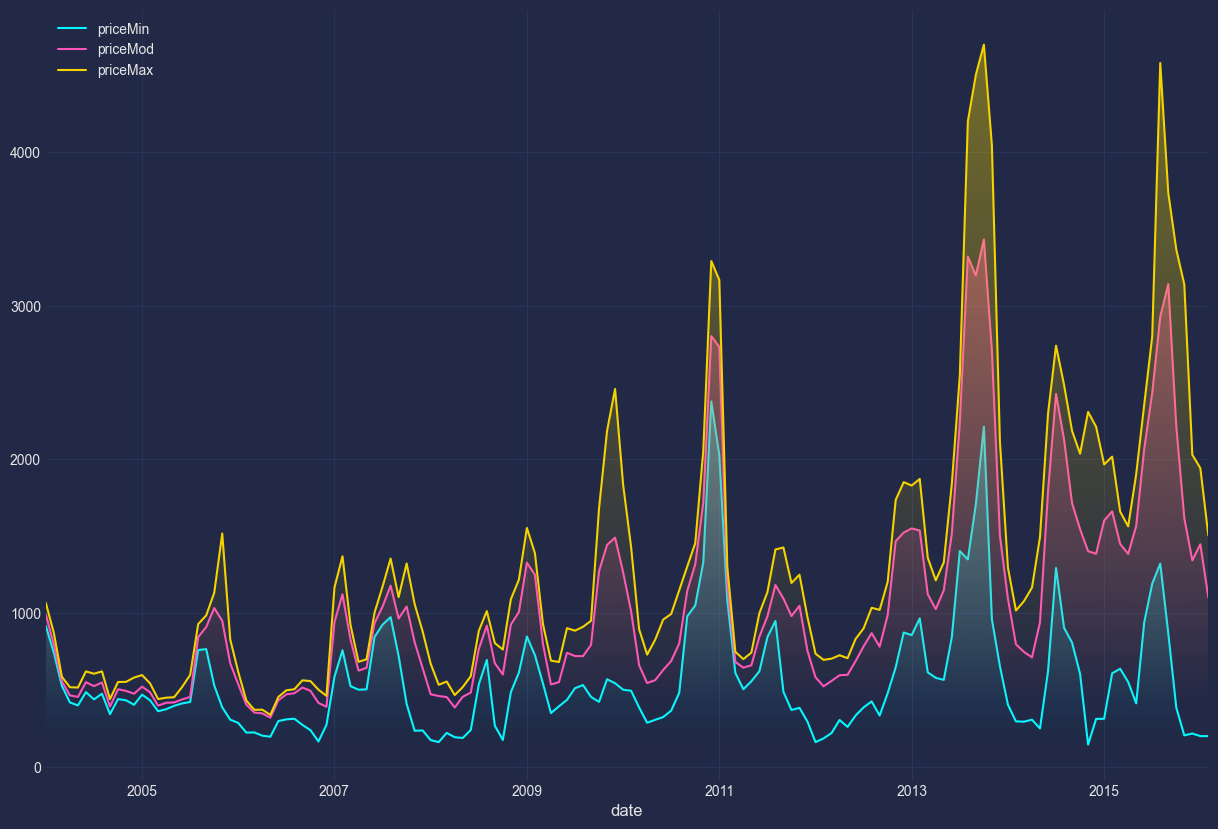

In [18]:
import mplcyberpunk

#plt.style.use('ggplot')
plt.style.use("cyberpunk")
plt.rcParams['figure.figsize'] = (15, 10)
dfBang.plot(kind = "line", y = ['priceMin', 'priceMod', 'priceMax'])
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)

In [19]:
# Transformamos a logaritmo para reducir la variablidad de la serie
dfBang['priceModLog'] = np.log(dfBang.priceMod)
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog
date,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,6.898715
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,6.675823
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,6.320768
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,6.142037
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,6.120297


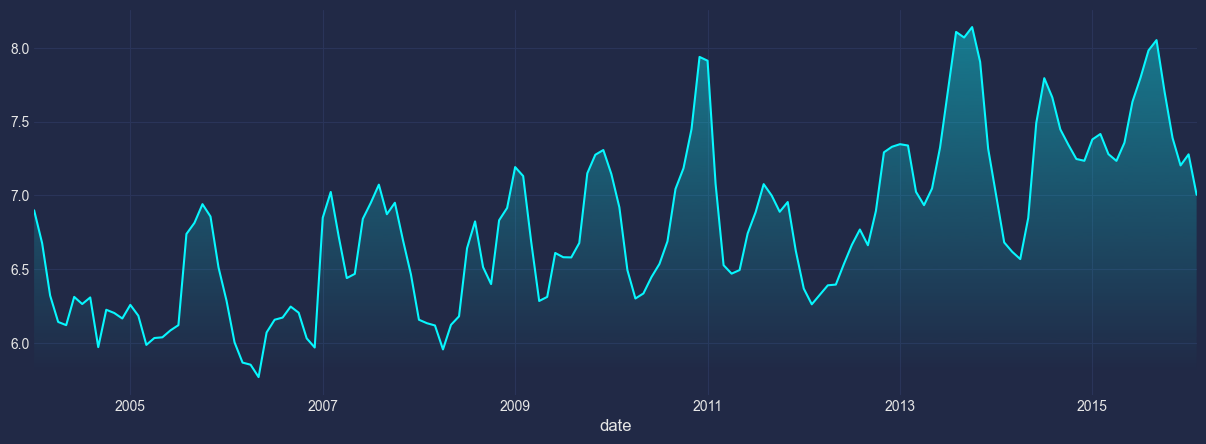

In [21]:
plt.rcParams['figure.figsize'] = (15, 5)
dfBang.priceModLog.plot();
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)

Como la transformación logaritmo no es lineal, observamos que las fluctuaciones son más parecidas entre sí al principio y al final de la serie.

## 2) Modelos básicos para prónosticos


    Modelo de la media constante
    Modelo de tendencia lineal
    Modelo Random Walk

La serie que vamos a intentar predecir con los siguientes modelos es la moda del precio mensual de la cebolla en el mercado de Bangalore.

### 2.a) Media constante

In [22]:
# Calculamos el promedio, uniforme para todos
model_mean_pred = dfBang.priceModLog.mean()

# Transformamos ese volor, inicialmente calculado en logaritmo
# Lo asignamos a una columna
dfBang["priceMean"] = np.exp(model_mean_pred)

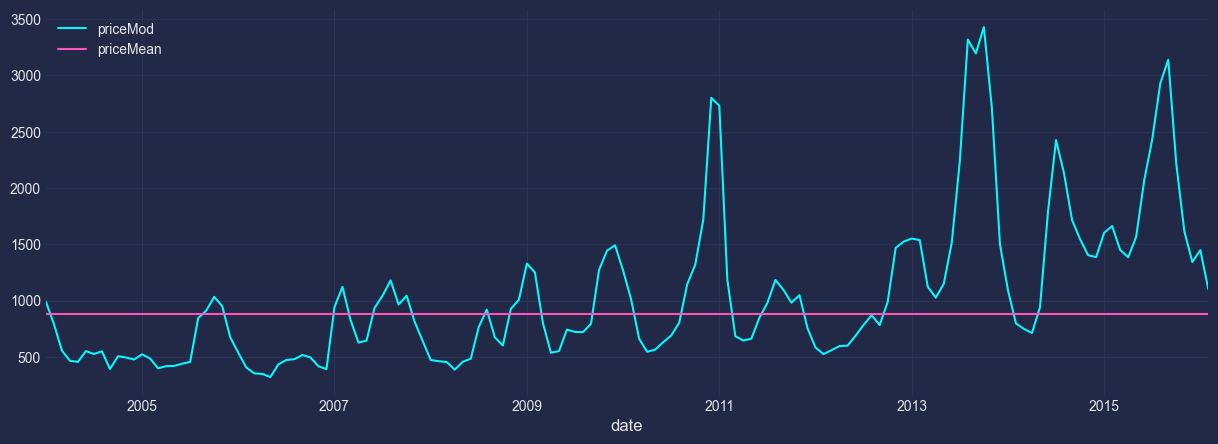

In [23]:
# Ploteamos los valores originales
dfBang.plot(kind="line", x="date", y = ["priceMod", "priceMean"]);

¿Cuán bien ajusta esta estimación?

In [24]:
# Calculemos el Error Cuadrático Medio y su raíz...
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [25]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

683.9533483996255

In [26]:
# Guardamos todo en un dataframe
dfBangResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfBangResults.loc[0,"Model"] = "Mean"
dfBangResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfBangResults.loc[0,"RMSE"] = model_mean_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.565812,683.953348


¿Cómo interpretás este resultado?

### 2.b) Tendencia lineal

Continuaremos trabajando con la tendencia lineal entre priceModLog y time. Primero tenemos que crear un indicador numérico para el período de tiempo para hacer una regresión lineal.

In [27]:
# Rotomamos el subset de Bangalore
# Identificamos el punto de inicio de la data
dfBang.date.min()

Timestamp('2004-01-01 00:00:00')

In [28]:
# Convertimos nuestra data almacenada en 'date' en datetime-delta, comenzando por cero
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex
date,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,6.898715,884.565812,0 days
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,6.675823,884.565812,31 days
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,6.320768,884.565812,60 days
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,6.142037,884.565812,91 days
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,6.120297,884.565812,121 days


In [29]:


# Transformamos la última columna de días a meses con timedelta
dfBang["timeIndex"] =  dfBang["timeIndex"]/np.timedelta64(1, 'M')
dfBang.timeIndex.head()



date
2004-01    0.000000
2004-02    1.018501
2004-03    1.971293
2004-04    2.989794
2004-05    3.975441
Freq: M, Name: timeIndex, dtype: float64

In [30]:
# Redondeamos, quitando todos los decimales
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)
dfBang.timeIndex.tail()

date
2015-10    141
2015-11    142
2015-12    143
2016-01    144
2016-02    145
Freq: M, Name: timeIndex, dtype: int32

In [31]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex
date,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,6.898715,884.565812,0
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,6.675823,884.565812,1
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,6.320768,884.565812,2
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,6.142037,884.565812,3
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,6.120297,884.565812,4


In [32]:
# Ahora fiteamos nuestro modelo de regresión lineal entre priceMod y timeIndex
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfBang).fit()

El primer argumento corresponde a la forma funcional de nuestra estimación.

In [33]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     139.8
Date:                Thu, 11 May 2023   Prob (F-statistic):           5.75e-23
Time:                        08:19:00   Log-Likelihood:                -72.317
No. Observations:                 146   AIC:                             148.6
Df Residuals:                     144   BIC:                             154.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1121      0.066     92.830      0.000       5.982       6.242
timeIndex      0.0093      0.001     11.823      0.000       0.008       0.011
==============================================================================
Omnibus:                        4.750   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.739
Skew:                           0.405   Prob(JB):                       0.0935
Kurtosis:                       2.648   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
model_linear_pred = model_linear.predict()
model_linear_pred[:5]

array([6.11210813, 6.12139074, 6.13067334, 6.13995594, 6.14923855])

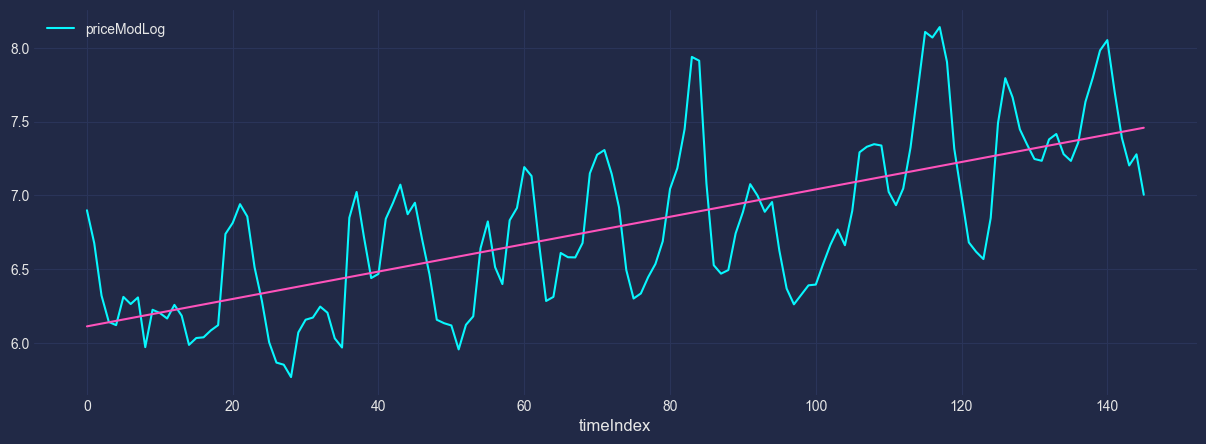

In [35]:
# Ploteamos los resultados de la predicción
dfBang.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(dfBang.timeIndex,model_linear_pred, '-');

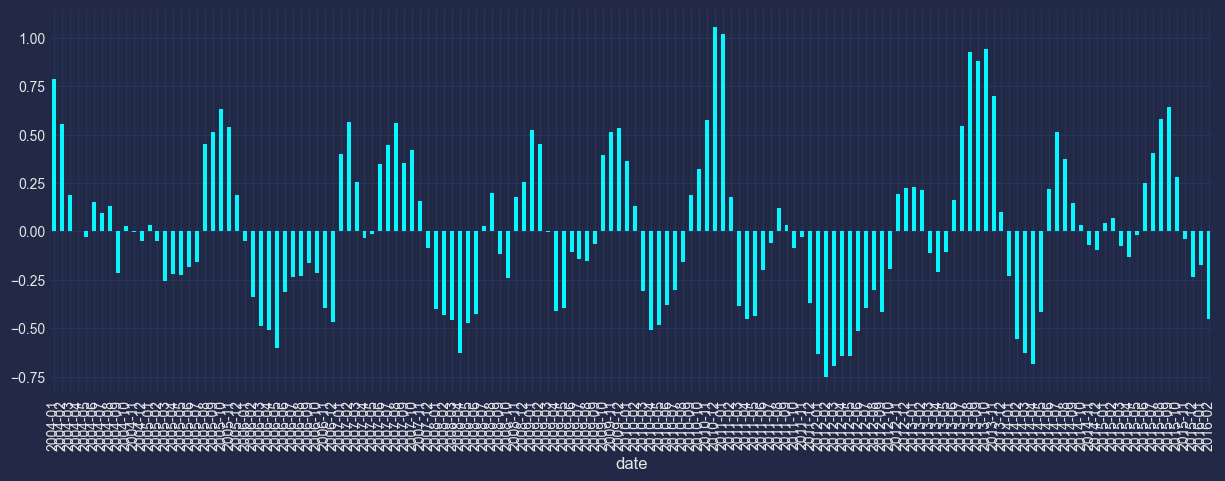

In [36]:
# Ploteamos los residuos de nuestra estimación
model_linear.resid.plot(kind = "bar");



    ¿Tenemos un mejor modelo respecto de la media constante? ¿Cómo podemos verificarlo?

En ambos gráficos vemos que el modelo de tendencia lineal es propenso a cometer un error del mismo signo durante varios períodos seguidos. Este sesgo del modelo se mide en términos estadísticos mediante la autocorrelación lag-1 (se denomina así a la correlación de una variable respecto a sí misma rezagada un período de tiempo) a través del estadístico Durbin-Watson. Si no hay un patrón de tiempo, la autocorrelación lag-1 debería ser muy cercana a cero (veamos el cuadro resumen del modelo más arriba) y, por lo tanto, la estadística de Durbin-Watson debería ser muy cercana a 2 (no es este caso). Si el modelo ha logrado extraer toda la "señal" de los datos, no debería haber ningún patrón en los errores, es decir, el error del período siguiente no debería estar correlacionado con ningún error anterior como observamos aquí. El modelo de tendencia lineal suele fallar cuando se testea la autocorrelación.


In [37]:
dfBang["priceLinear"] = np.exp(model_linear_pred)
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear
date,,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,6.898715,884.565812,0,451.289090
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,6.675823,884.565812,1,455.497732
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,6.320768,884.565812,2,459.745622
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,6.142037,884.565812,3,464.033127
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,6.120297,884.565812,4,468.360617


In [38]:


# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

518.5236075841487

In [39]:


# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
dfBangResults.loc[1,"Model"] = "Linear"
dfBangResults.loc[1,"Forecast"] = np.exp(model_linear_pred)
dfBangResults.loc[1,"RMSE"] = model_linear_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.565812,683.953348
1,Linear,"[451.28909037437916, 455.4977316072932, 459.74...",518.523608


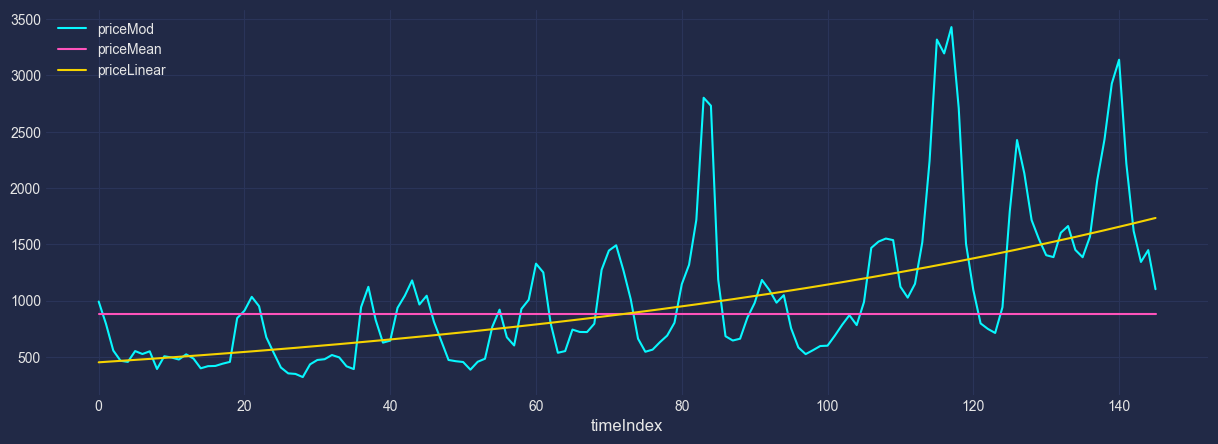

In [40]:
# Ploteamos las dos estimaciones
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear"]);


**Tendencia lineal con un regresor**

Ahora vamos a explorar un modelo lineal que permite tener en cuenta la cantidad. Cuando incluimos un feature adicional (además del tiempo) en una serie de tiempo existen dos posibilidades:

    El regresor se conoce a la hora de pronosticar: por ejemplo la ubicación donde la empresa estará en un momento del tiempo, que ya puede estar planificada.
    El regresor no se conoce a la hora de pronosticar: por ejemplo la cantidad en este caso

Cuando nos encontramos en el segundo escenario, tenemos que tener en cuenta que el modelo de serie de tiempo va a ser útil para entender las relaciones entre las variables recurriendo al pasado (es decir, para modelar) pero no para hacer pronósticos a futuro.


In [41]:


# Ahora estimamos una variante del modelo lineal, incluyendo el logaritmo de las cantidades como regresor
model_linear_quantity = smf.ols('priceModLog ~ timeIndex + np.log(quantity)', data = dfBang).fit()
model_linear_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     74.16
Date:                Thu, 11 May 2023   Prob (F-statistic):           8.00e-23
Time:                        08:21:29   Log-Likelihood:                -69.892
No. Observations:                 146   AIC:                             145.8
Df Residuals:                     143   BIC:                             154.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1813      0.881      4.746      0.000       2.440       5.923
timeIndex            0.0084      0.001      9.774      0.000       0.007       0.010
np.log(quantity)     0.1529      0.070      2.198      0.030       0.015       0.290
==============================================================================
Omnibus:                        5.097   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.952
Skew:                           0.403   Prob(JB):                       0.0841
Kurtosis:                       2.593   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:


dfBang["priceLinearQuantity"] = np.exp(model_linear_quantity.predict())

In [43]:


model_linear_quantity.params

Intercept           4.181290
timeIndex           0.008443
np.log(quantity)    0.152863
dtype: float64

In [44]:
# Calculamos el RMSE y lo añadimos al DF de resultados
dfBangResults.loc[2,"Model"] = "LinearQuantity"
dfBangResults.loc[2,"Forecast"] = np.exp(model_linear_quantity.params[0] + 
                                        model_linear_quantity.params[1] * 146 +
                                        model_linear_quantity.params[2] * np.log(4000000))
dfBangResults.loc[2,"RMSE"] = RMSE(dfBang.priceLinearQuantity, dfBang.priceMod)
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.565812,683.953348
1,Linear,"[451.28909037437916, 455.4977316072932, 459.74...",518.523608
2,LinearQuantity,2293.446388,505.249101


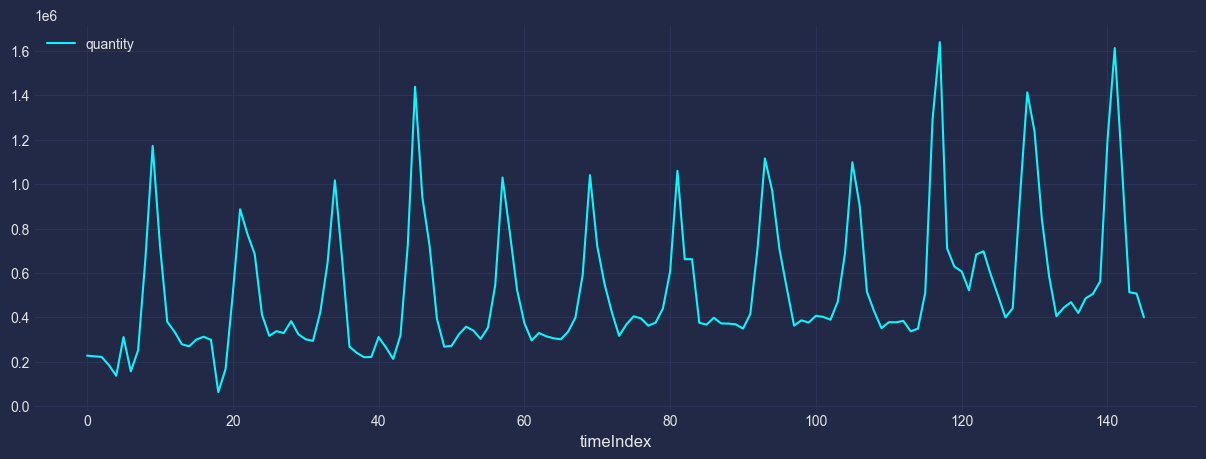

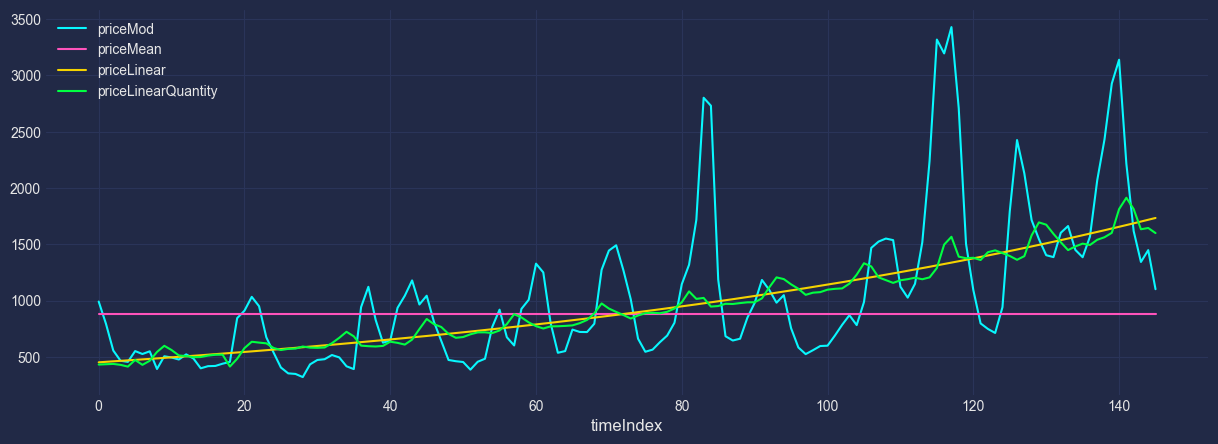

In [45]:
dfBang.plot(kind = "line", x="timeIndex", y = "quantity")
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", 
                                             "priceLinear", "priceLinearQuantity"]);

### 2.c) Random Walk

Cuando nos enfrentamos a una serie de tiempo que muestra crecimiento irregular, la mejor estrategia no es tratar de predecir directamente el nivel de la serie en cada período (es decir, el valor Yt), sino el cambio que ocurre de un período al siguiente (es decir, la diferencia Yt - Yt-1). Se observa la primera diferencia (o lag) de la serie para encontrar un patrón predecible.

A los efectos del pronóstico del próximo período, puede ser tan bueno predecir el nivel como la variación, ya que el cambio predicho puede agregarse al nivel actual para generar un nivel pronosticado. El caso más simple de dicho modelo es uno que siempre predice que el siguiente cambio será cero, como si la serie tuviera la misma probabilidad de subir o bajar en el próximo período, independientemente de lo que haya sucedido en el pasado.

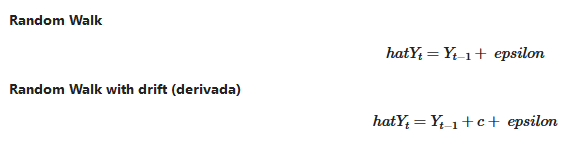

In [46]:


# Generamos el desplazamiento de nuestro nuestro target (lag=1)
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1
date,,,,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,6.898715,884.565812,0,451.289090,431.410971,NaN
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,6.675823,884.565812,1,455.497732,434.277110,6.898715
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,6.320768,884.565812,2,459.745622,437.007747,6.675823
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,6.142037,884.565812,3,464.033127,428.667281,6.320768
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,6.120297,884.565812,4,468.360617,413.029454,6.142037


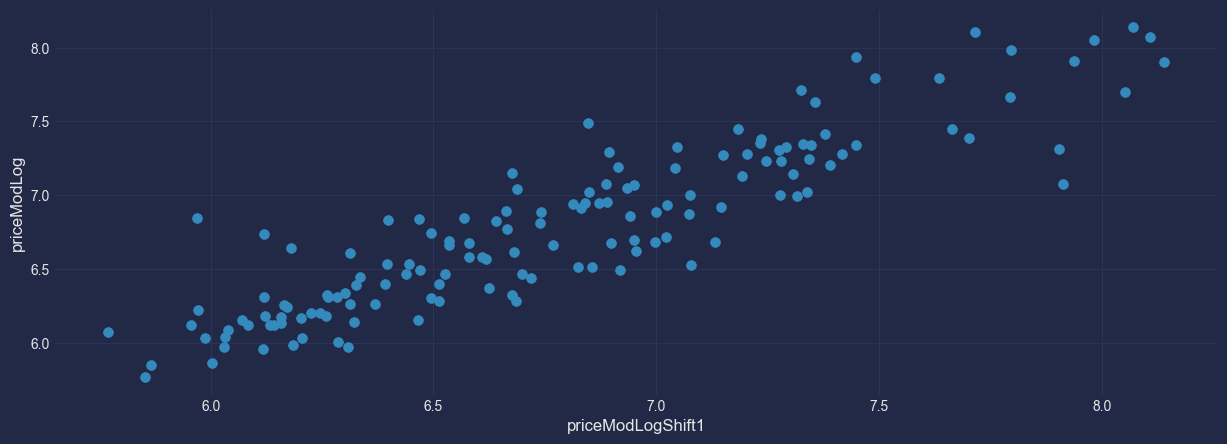

In [47]:


dfBang.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50);

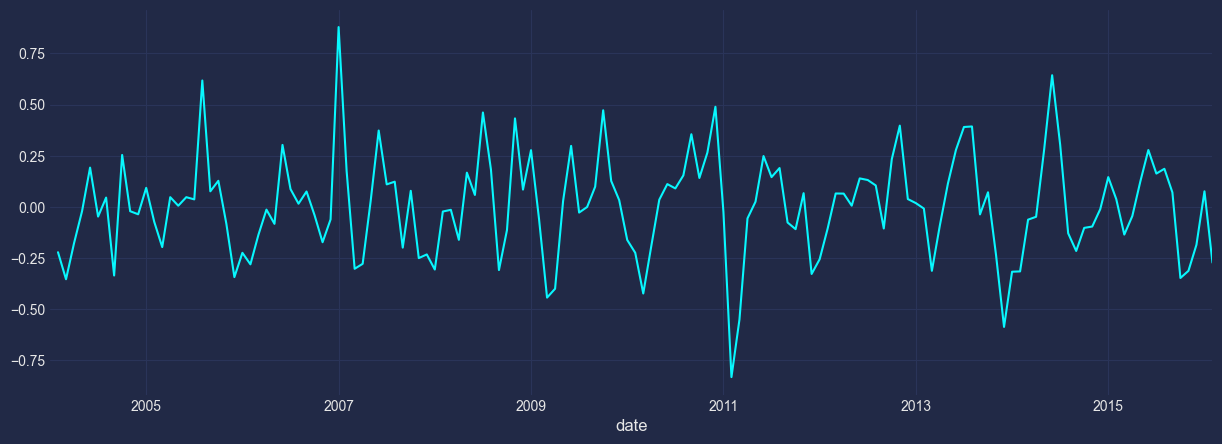

In [48]:
# Ploteamos la relación entre nuestro target y el lag de un período
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1
dfBang.priceModLogDiff.plot();

In [49]:


dfBang["priceRandom"] = np.exp(dfBang.priceModLogShift1)
dfBang.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom
date,,,,,,,,,,,,,,,,,,
2015-10,BANGALORE,October,2015,1612160,385,3365,2215,KNT,BANGALORE,2015-10-01,7.703008,884.565812,141,1670.628673,1913.491280,8.051978,-0.348970,3140.0
2015-11,BANGALORE,November,2015,1071872,205,3138,1618,KNT,BANGALORE,2015-11-01,7.388946,884.565812,142,1686.208656,1812.993037,7.703008,-0.314062,2215.0
2015-12,BANGALORE,December,2015,513186,217,2030,1343,KNT,BANGALORE,2015-12-01,7.202661,884.565812,143,1701.933936,1633.680427,7.388946,-0.186285,1618.0
2016-01,BANGALORE,January,2016,507223,200,1943,1448,KNT,BANGALORE,2016-01-01,7.277939,884.565812,144,1717.805867,1644.591721,7.202661,0.075277,1343.0
2016-02,BANGALORE,February,2016,400359,200,1505,1101,KNT,BANGALORE,2016-02-01,7.003974,884.565812,145,1733.825817,1599.625994,7.277939,-0.273964,1448.0


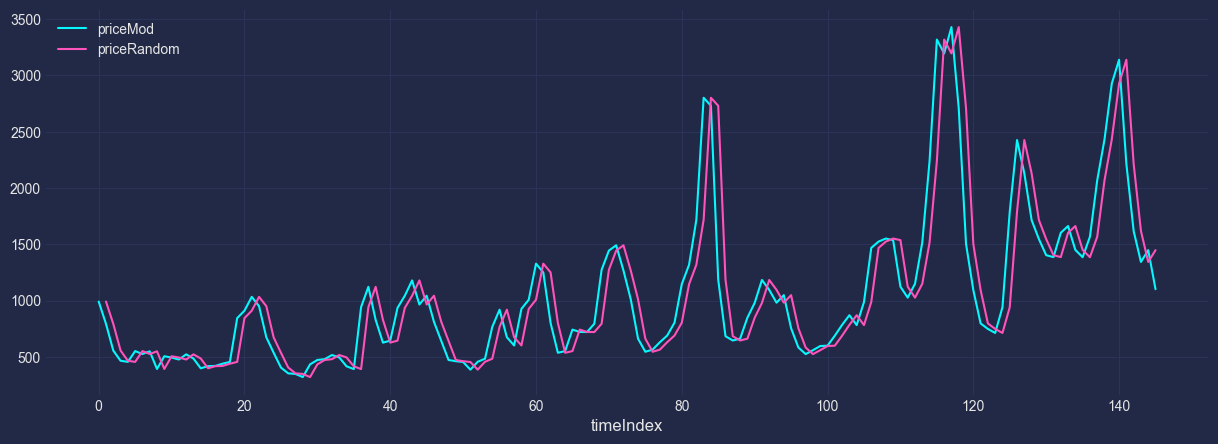

In [50]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod","priceRandom"]);

In [51]:
# Calculamos el RMSE y almacenamos los resultados
dfBangResults.loc[3,"Model"] = "Random"
dfBangResults.loc[3,"Forecast"] = np.exp(dfBang.priceModLogShift1[-1])
dfBangResults.loc[3,"RMSE"] = RMSE(dfBang.priceRandom, dfBang.priceMod)
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.565812,683.953348
1,Linear,"[451.28909037437916, 455.4977316072932, 459.74...",518.523608
2,LinearQuantity,2293.446388,505.249101
3,Random,1448.0,323.5924


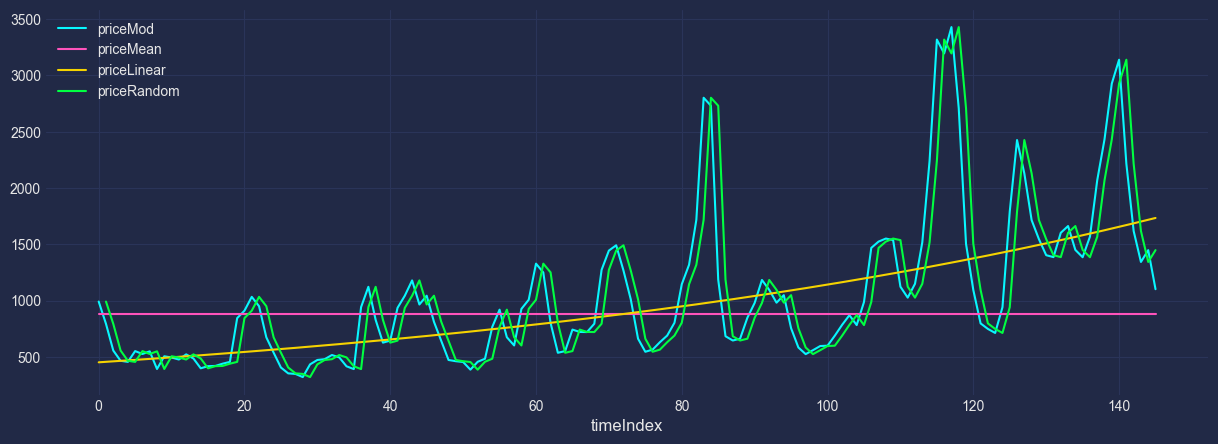

In [52]:


dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom"]);

**BASE para el ANÁLISIS de las SERIES de TIEMPO**

La mayoría de los modelos de series de tiempo funcionan bajo el supuesto de que la serie temporal es estacionaria. Intuitivamente, podemos ver que si una serie de tiempo tiene un comportamiento particular a lo largo del tiempo, existe una gran probabilidad de que siga igual en el futuro. Además, las herramientas relacionadas con series estacionarias han sido más desarrolladas y son más fáciles de implementar que aquellas relacionadas con series que no lo son.

Los models AR y MA requieren para funcionar que la serie sea estacional. La evolución de estos dos modelos, ARIMA, a diferencia de éstos puede trabajar con series no estacionales.

**Estacionariedad estadística**: una serie temporal estacionaria es aquella cuyas propiedades estadísticas tales como media, varianza, autocorrelación, etc. son todas constantes a lo largo del tiempo. La mayoría de los métodos de pronóstico estadístico se basan en la suposición de que las series de tiempo pueden ser representadas como estacionarias (es decir, "desestacionalizadas") mediante el uso de transformaciones matemáticas. Una serie estacionaria es relativamente fácil de predecir: ¡simplemente predice que sus propiedades estadísticas serán las mismas en el futuro que en el pasado!

Hay tres criterios básicos para que una serie se clasifique como serie estacionaria:

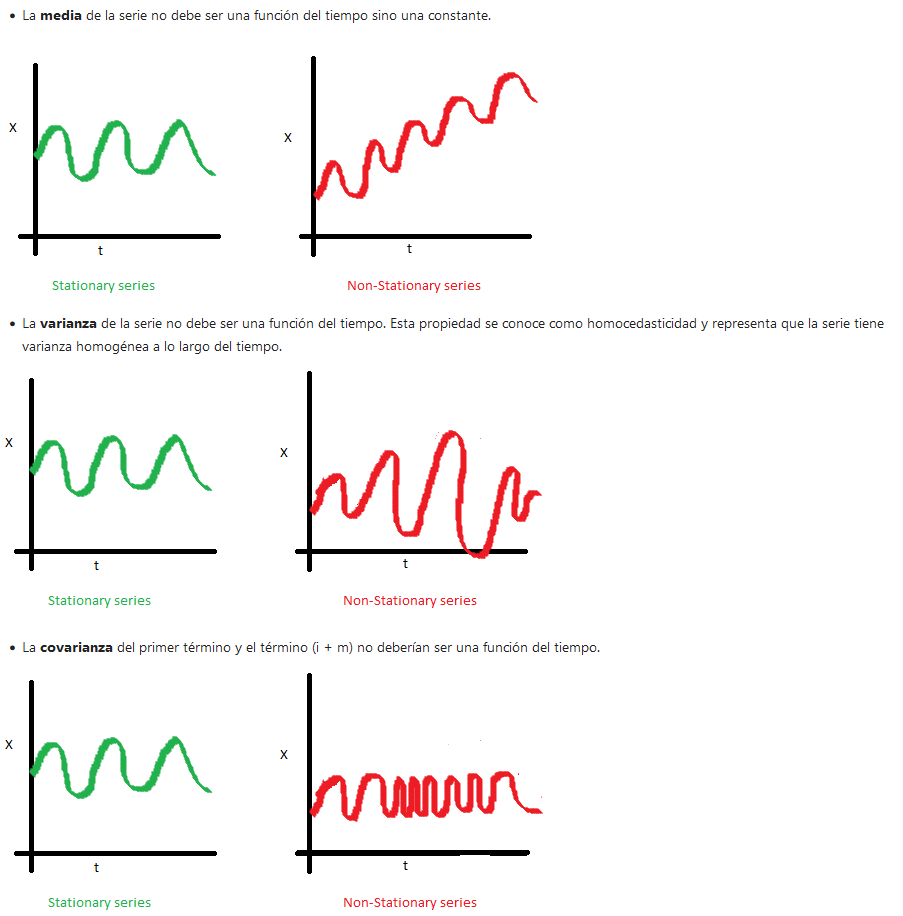

**¿Cómo hacemos para que una serie de tiempo sea estacionaria?**

Hay 3 componentes centrales vinculados con la no estacionariedad de la serie de tiempo:

- Tendencia (T): existe una tendencia cuando hay un aumento o una disminución del nivel (de la variable en cuestión) a largo plazo. No tiene que ser lineal. A veces nos referiremos a un cambio en la dirección (punto de inflexión) de la serie cuando la tendencia pasa de ser creciente a decreciente.
- Estacionalidad (S por seasonality): existe un patrón estacional cuando una serie está influenciada por factores estacionales (por ejemplo, el trimestre del año en lo que refiere a vacaciones o zafra; el mes si contemplamos crecimiento de ventas (ligado a Navidad, por ejemplo) o el día de la semana). La estacionalidad es siempre de un período fijo y conocido.
- Cíclico: existe un patrón cíclico cuando los datos exhibidos suben y bajan sin respetar el período fijo ligado a la estacionalidad. La duración de estas fluctuaciones suele ser de al menos 2 años. Si estuviésemos analizando el PBI de un país, los ciclos económicos con años de crecimiento seguidos de otros de recesión constituyen un buen ejemplo. Sin embargo, cuando hay poca información o las variaciones cíclicas no son muy pronunciadas, este componente puede quedar subsumido al de la tendencia.

Podemos describir el comportamiento de la serie a partir de un modelo aditivo: 

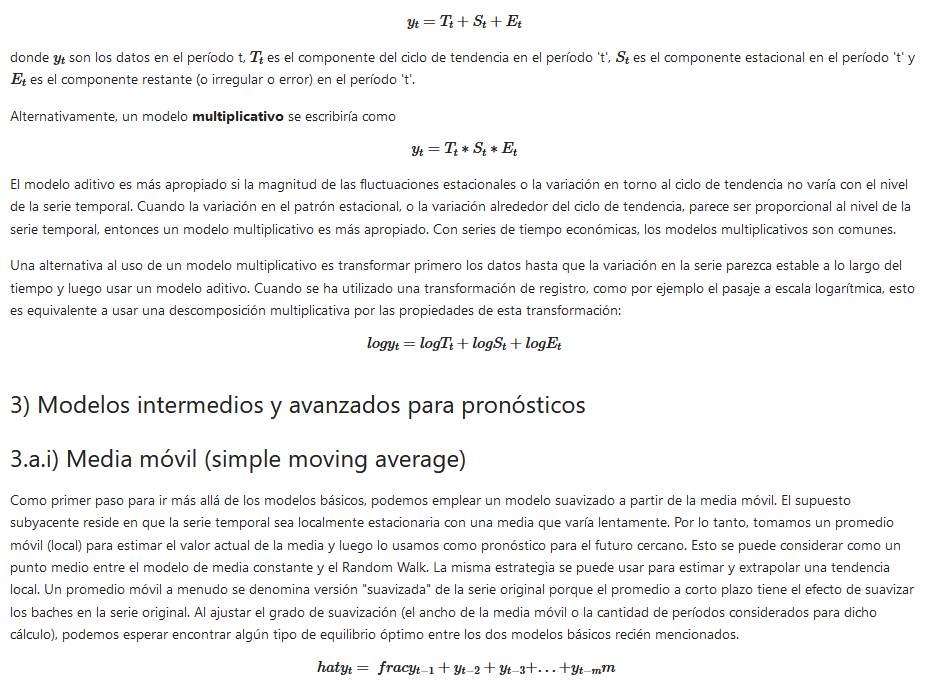

## 3) Modelos intermedios y avanzados para pronósticos

### 3.a.i) Media móvil (simple moving average)

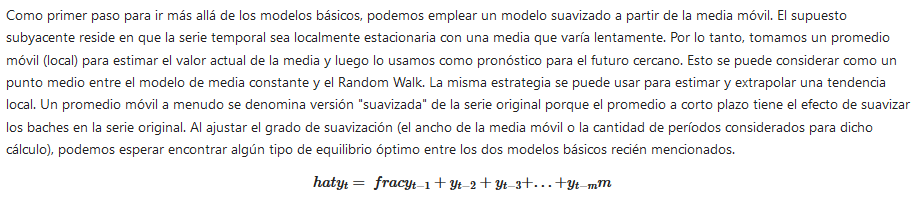

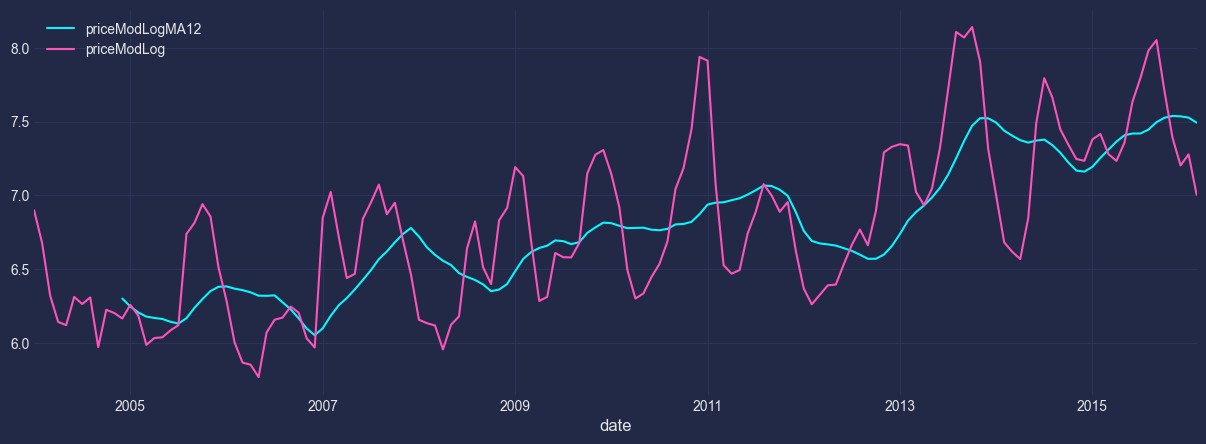

In [53]:
# Calculamos la media móvil de 12 meses para suavizar los valores y ploteamos
dfBang['priceModLogMA12'] = dfBang.priceModLog.rolling(window = 12).mean()
dfBang.plot(kind ="line", y=["priceModLogMA12", "priceModLog"]);

In [54]:
dfBang["priceMA12"] = np.exp(dfBang.priceModLogMA12)
dfBang.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12
date,,,,,,,,,,,,,,,,,,,,
2015-10,BANGALORE,October,2015,1612160,385,3365,2215,KNT,BANGALORE,2015-10-01,7.703008,884.565812,141,1670.628673,1913.491280,8.051978,-0.348970,3140.0,7.526074,1855.805596
2015-11,BANGALORE,November,2015,1071872,205,3138,1618,KNT,BANGALORE,2015-11-01,7.388946,884.565812,142,1686.208656,1812.993037,7.703008,-0.314062,2215.0,7.537956,1877.986866
2015-12,BANGALORE,December,2015,513186,217,2030,1343,KNT,BANGALORE,2015-12-01,7.202661,884.565812,143,1701.933936,1633.680427,7.388946,-0.186285,1618.0,7.535329,1873.061120
2016-01,BANGALORE,January,2016,507223,200,1943,1448,KNT,BANGALORE,2016-01-01,7.277939,884.565812,144,1717.805867,1644.591721,7.202661,0.075277,1343.0,7.526907,1857.351582
2016-02,BANGALORE,February,2016,400359,200,1505,1101,KNT,BANGALORE,2016-02-01,7.003974,884.565812,145,1733.825817,1599.625994,7.277939,-0.273964,1448.0,7.492590,1794.694278


In [55]:
# Incorporamos estimaciones y resultados a nuestro DF
dfBangResults.loc[4,"Model"] = "Moving Average 12"
dfBangResults.loc[4,"Forecast"] = np.exp(dfBang.priceModLog.tail(12).mean())
dfBangResults.loc[4,"RMSE"] = RMSE(dfBang.priceMA12, dfBang.priceMod)

dfBang.priceModLog.tail(12).mean()
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.565812,683.953348
1,Linear,"[451.28909037437916, 455.4977316072932, 459.74...",518.523608
2,LinearQuantity,2293.446388,505.249101
3,Random,1448.0,323.5924
4,Moving Average 12,1794.694278,518.821751


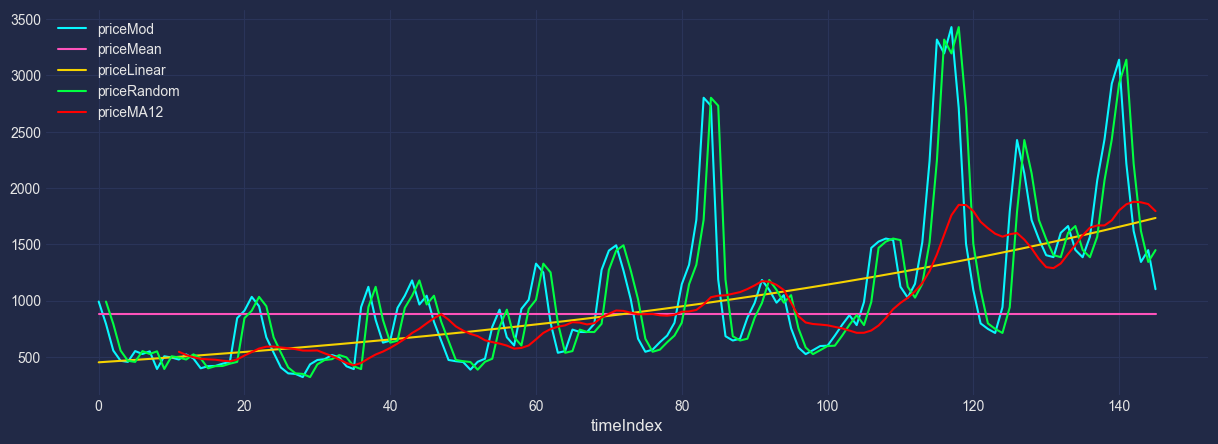

In [56]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear",
                                             "priceRandom", "priceMA12"]);

En ambos casos, podemos rechazar la hipótesis nula y, por lo tanto, considerar la serie como estacionaria.

### 3.b.ii) Modelo ARIMA

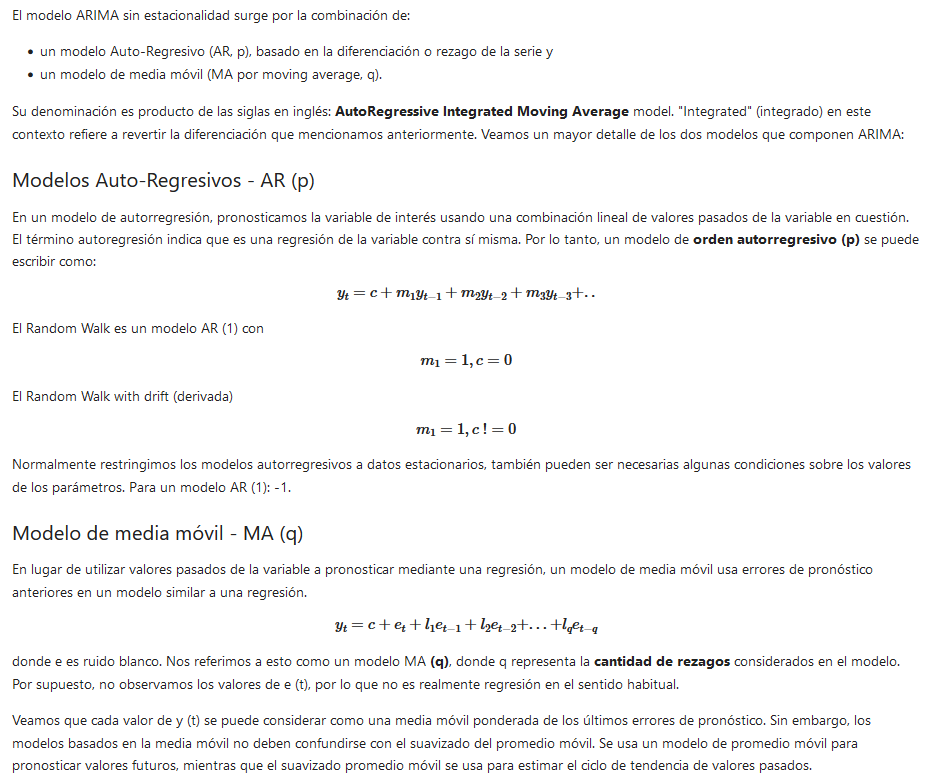

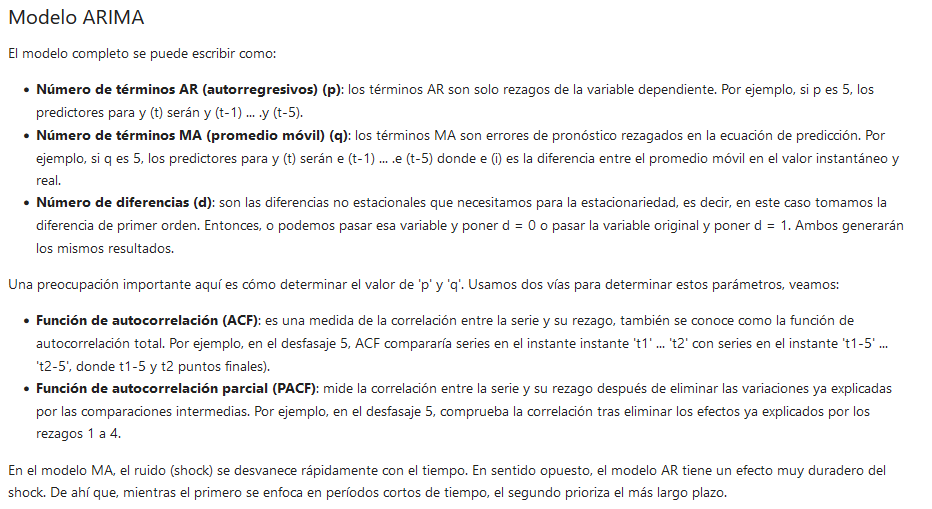

In [57]:


ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace = True)

In [58]:
# Importamos plots ACF y PACF
from statsmodels.tsa.stattools import acf, pacf

In [59]:


lag_acf = acf(ts_diff, nlags=20)
lag_acf

array([ 1.        ,  0.40215445, -0.02855346, -0.21472715, -0.23756032,
       -0.26332645, -0.22038359, -0.08576989, -0.0754398 ,  0.01497797,
        0.12361818,  0.20862956,  0.158123  ,  0.02053933, -0.01290934,
       -0.07097602, -0.17993659, -0.09514604, -0.04878255, -0.08854117,
       -0.18810881])

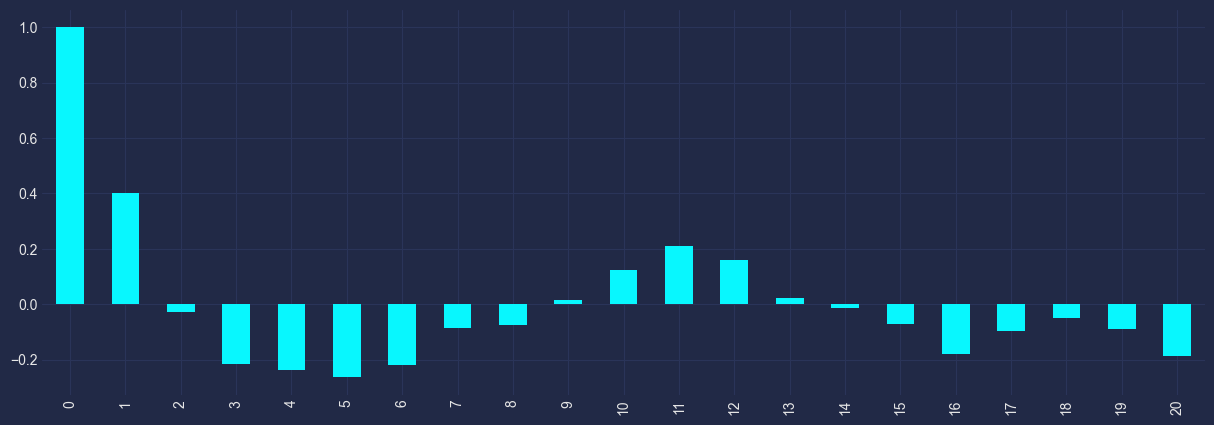

In [60]:


ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [61]:


lag_pacf = pacf(ts_diff, nlags=20, method='ols');

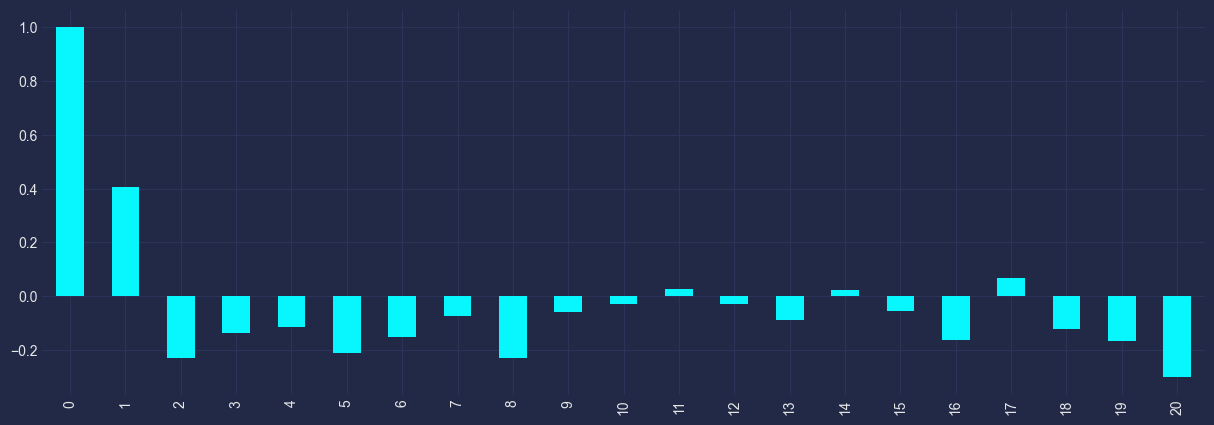

In [62]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

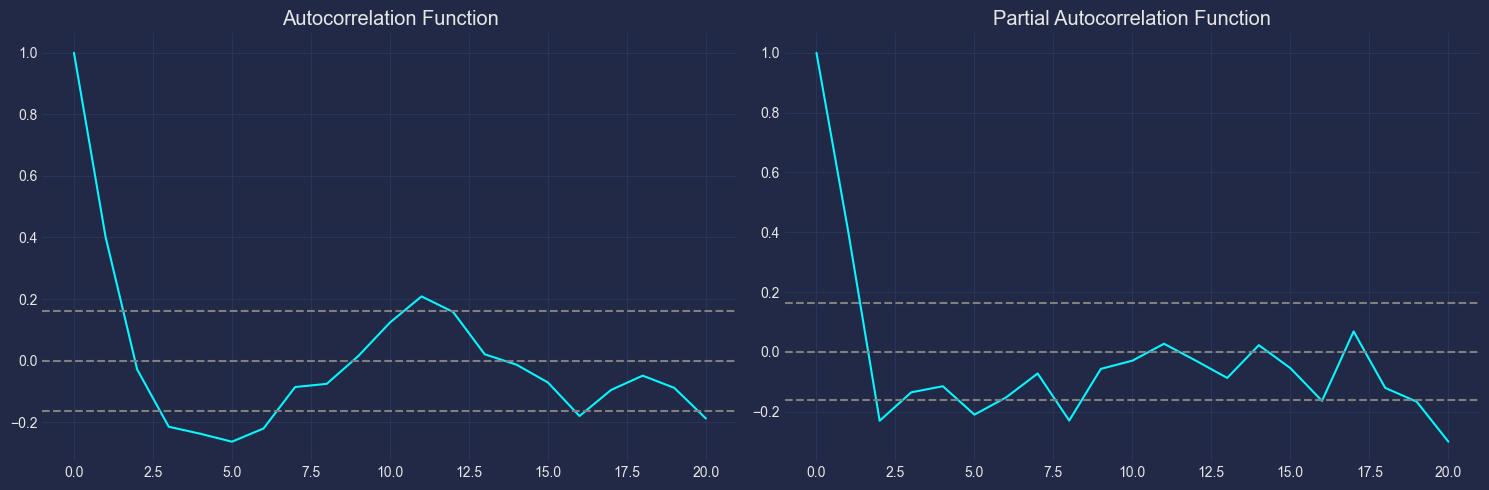

In [63]:
# Veamos qué parámetros son significativamente distintos de cero

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

En el modelo de autocorrelación parcial el primer order es estadísticamente significativo y en los períodos siguientes el shock se licúa y los parámetros son cercanos a 0. Es por esto que vamos a elegir un modelo AR(1) y MA(1).

### Modelando con ARIMA

In [67]:
from statsmodels.tsa.arima.model import ARIMA
ts.head()

date
2004-01    6.898715
2004-02    6.675823
2004-03    6.320768
2004-04    6.142037
2004-05    6.120297
Freq: M, Name: priceModLog, dtype: float64

In [68]:


# Instancio el modelo con parámetros (p=1,d=0,q=1) según el análisis de ACF y PACF
# En este caso d=0 porque trabajamos directamente con las diferencias
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

# Fiteo el modelo
results_ARIMA = model_AR1MA.fit()
results_ARIMA.fittedvalues.head()



date
2004-02   -0.000983
2004-03   -0.093810
2004-04   -0.139363
2004-05   -0.041734
2004-06    0.002160
Freq: M, dtype: float64

In [69]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:        priceModLogDiff   No. Observations:                  145
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  12.361
Date:                Thu, 11 May 2023   AIC                            -16.721
Time:                        08:34:08   BIC                             -4.814
Sample:                    02-29-2004   HQIC                           -11.883
                         - 02-29-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.030     -0.032      0.974      -0.061       0.059
ar.L1          0.1582      0.217      0.730      0.466      -0.267       0.583
ma.L1          0.3215      0.186      1.733      0.0

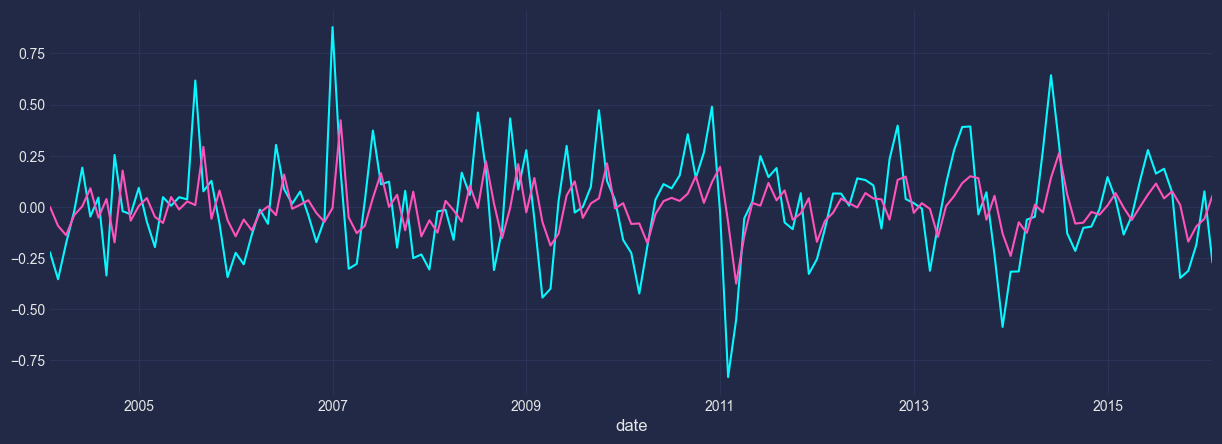

In [70]:


ts_diff.plot()
results_ARIMA.fittedvalues.plot();

In [71]:


ts_diff.sum()

0.1052596023926915

In [72]:


predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

date
2015-10    0.008534
2015-11   -0.170976
2015-12   -0.096514
2016-01   -0.059159
2016-02    0.054304
Freq: M, dtype: float64

In [73]:


predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

date
2015-10    0.343822
2015-11    0.172846
2015-12    0.076332
2016-01    0.017173
2016-02    0.071477
Freq: M, dtype: float64

In [74]:


ts.iloc[0]

6.898714534329988

In [75]:
predictions_ARIMA_log = pd.Series(ts.iloc[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

date
2015-10    7.242536
2015-11    7.071561
2015-12    6.975047
2016-01    6.915887
2016-02    6.970191
Freq: M, dtype: float64

In [76]:


# Guardamos nuestros resultados
dfBang['priceARIMA'] = np.exp(predictions_ARIMA_log)

In [77]:
# Incorporamos estimaciones y resultados a nuestro DF
dfBangResults.loc[5,"Model"] = "ARIMA"
dfBangResults.loc[5,"Forecast"] = dfBang.priceARIMA[-1]
dfBangResults.loc[5,"RMSE"] = RMSE(dfBang.priceARIMA, dfBang.priceMod)

In [78]:
dfBangResults.head(10)

,Model,Forecast,RMSE
0,Mean,884.565812,683.953348
1,Linear,"[451.28909037437916, 455.4977316072932, 459.74...",518.523608
2,LinearQuantity,2293.446388,505.249101
3,Random,1448.0,323.5924
4,Moving Average 12,1794.694278,518.821751
5,ARIMA,1064.426332,517.748047


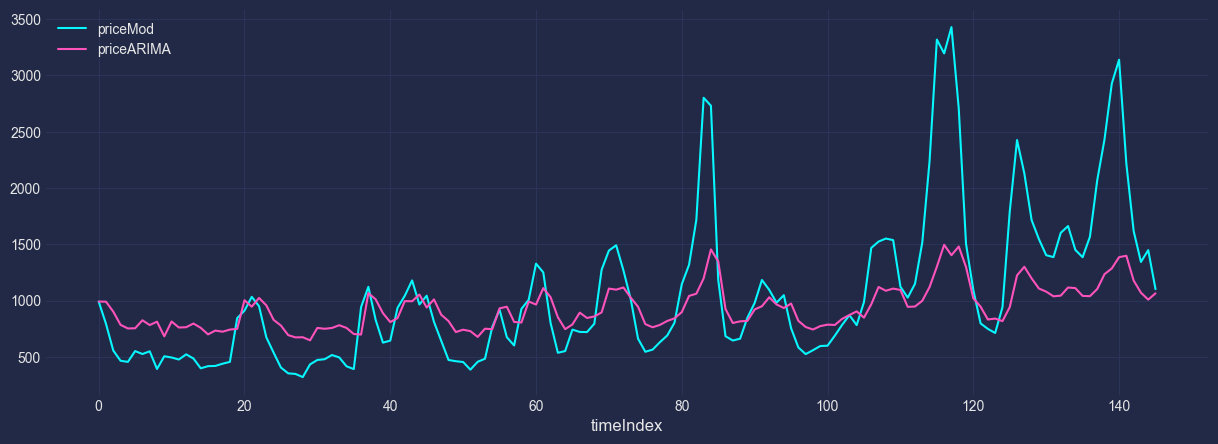

In [79]:


dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceARIMA"]);

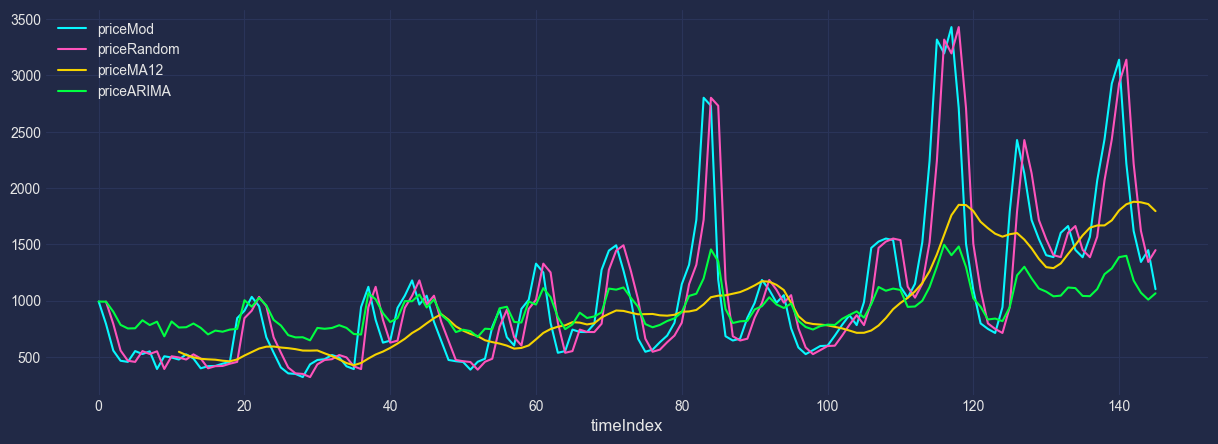

In [80]:


dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceRandom",
                                             "priceMA12", "priceARIMA"]);



¿Qué modelo performa mejor? ¿Elegirías alguno? ¿Por qué?